In [ ]:
%pip install hcp_utils

In [2]:
import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
#replace with your own path to the data
path='hcp_retino/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii'
img = nib.load(f'{path}')
X = img.get_fdata()
X.shape    

(300, 91282)

In [5]:
hcp.struct.keys()
for key in hcp.struct.keys():
    print(f'{key},{hcp.struct[key]}')

cortex_left,slice(0, 29696, None)
cortex_right,slice(29696, 59412, None)
cortex,slice(0, 59412, None)
subcortical,slice(59412, None, None)
accumbens_left,slice(59412, 59547, None)
accumbens_right,slice(59547, 59687, None)
amygdala_left,slice(59687, 60002, None)
amygdala_right,slice(60002, 60334, None)
brainStem,slice(60334, 63806, None)
caudate_left,slice(63806, 64534, None)
caudate_right,slice(64534, 65289, None)
cerebellum_left,slice(65289, 73998, None)
cerebellum_right,slice(73998, 83142, None)
diencephalon_left,slice(83142, 83848, None)
diencephalon_right,slice(83848, 84560, None)
hippocampus_left,slice(84560, 85324, None)
hippocampus_right,slice(85324, 86119, None)
pallidum_left,slice(86119, 86416, None)
pallidum_right,slice(86416, 86676, None)
putamen_left,slice(86676, 87736, None)
putamen_right,slice(87736, 88746, None)
thalamus_left,slice(88746, 90034, None)
thalamus_right,slice(90034, None, None)


In [7]:
# truncated response data, limited to left cortex
X_hipL = X[:, hcp.struct.cortex_left]

print(X_hipL.shape) # (300,29696), matches glasser data

(300, 29696)


In [6]:
import pandas as pd
glasser_labels = pd.read_csv('Glasser.csv', header=None)

In [8]:
glasser_filename='glasser_labels.nii'
image=nib.load(f'{glasser_filename}')
glasser_data = image.get_fdata().squeeze()
print(glasser_data.shape)  # (29696, )

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(29696,)


In [9]:
glasser_labels.columns = ['Index', 'LabelName']
print(glasser_labels[['Index', 'LabelName']])

     Index                      LabelName
0        1          Primary_visual_cortex
1        2  Medial_superior_temporal_area
2        3              Sixth_Visual_Area
3        4             Second_Visual_Area
4        5              Third_Visual_Area
..     ...                            ...
175    176             Area_STSv_Anterior
176    177                Area_TE1_Middle
177    178              Para-Insular_Area
178    179         Area_Anterior_32_Prime
179    180              Area_Posterior_24

[180 rows x 2 columns]


In [10]:
v1_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Primary_visual_cortex', 'Index'].values[0]
v2_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Second_Visual_Area', 'Index'].values[0]
v3_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Third_Visual_Area', 'Index'].values[0]
print(v1_label, v2_label, v3_label)

1 4 5


In [11]:
v1_voxels = np.where(glasser_data == v1_label)[0]  
v2_voxels = np.where(glasser_data == v2_label)[0]  
v3_voxels = np.where(glasser_data == v3_label)[0]  
print(f"V1 index from {v1_voxels.min()} to {v1_voxels.max()}")
print(f"V2 index from {v2_voxels.min()} to {v2_voxels.max()}")
print(f"V3 index from {v3_voxels.min()} to {v3_voxels.max()}")

V1 index from 55 to 24020
V2 index from 65 to 24087
V3 index from 10127 to 23909


In [12]:
v1_mask = np.isin(glasser_data, v1_label)
v2_mask = np.isin(glasser_data, v2_label)
v3_mask = np.isin(glasser_data, v3_label)

In [15]:
def generate_rotating_wedge_stimulus(n_frames=300,
                        height=200,
                        width=200,
                        wedge_width_deg=90,
                        cycle_duration=32,
                        n_cycles=8,
                        blank_duration=22,
                        direction='ccw',
                        radius_px=100):
    """
    Generates a binary stimulus matrix representing a rotating wedge stimulus.

    Parameters:
    - n_frames: total number of frames (TRs), default 300
    - height, width: spatial resolution in pixels
    - visual_field_deg: total size of visual field in degrees (assumed square)
    - wedge_width_deg: angular width of the rotating wedge
    - cycle_duration: seconds per full 360° rotation (1 cycle)
    - n_cycles: number of full cycles
    - blank_duration: seconds of blank at start and end
    - direction: 'ccw' or 'cw' (counterclockwise or clockwise)

    Returns:
    - stimulus: array of shape (n_frames, height, width) with binary apertures
    """
    # coordinates
    x_pix = np.linspace(-width // 2, width // 2, width)
    y_pix = np.linspace(-height // 2, height // 2, height)
    xv, yv = np.meshgrid(x_pix, y_pix)

    # polar representation
    polar_angle = (np.degrees(np.arctan2(yv, xv)) + 360) % 360
    radius = np.sqrt(xv**2 + yv**2)

    frames_per_cycle = int(cycle_duration)
    blank_frames = int(blank_duration)

    stimulus = np.zeros((n_frames, height, width))

    for t in range(blank_frames, n_frames - blank_frames):
        cycle_pos = (t - blank_frames) % frames_per_cycle
        angle = (360 * cycle_pos / frames_per_cycle) % 360

        if direction == 'cw':
            angle = (360 - angle) % 360

        # mask
        angle_diff = (polar_angle - angle + 180) % 360 - 180
        wedge_mask = np.abs(angle_diff) <= wedge_width_deg / 2

        radius_mask = radius <= radius_px

        final_mask = wedge_mask & radius_mask
        stimulus[t][final_mask] = 1.0

    return stimulus


In [16]:
def make_prf_matrix(x0_pix, y0_pix, sigma_pix, height=200, width=200):
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xv, yv = np.meshgrid(x, y)
    prf = np.exp(-((xv - x0_pix)**2 + (yv - y0_pix)**2) / (2 * sigma_pix**2))
    return prf

In [17]:
def simulate_voxel_response(stimulus, prf):
    # Dot product over (H, W) for each timepoint
    response = np.tensordot(stimulus, prf, axes=([1, 2], [0, 1]))
    return response

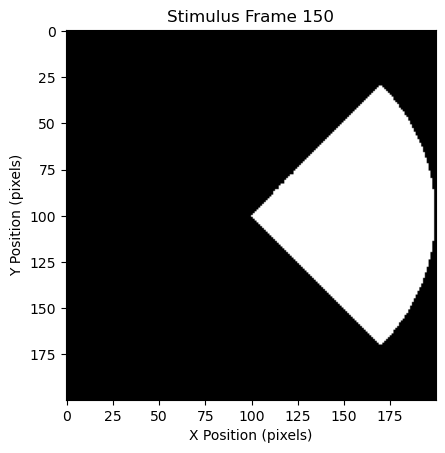

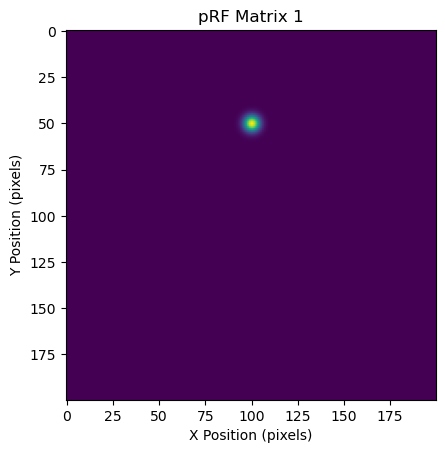

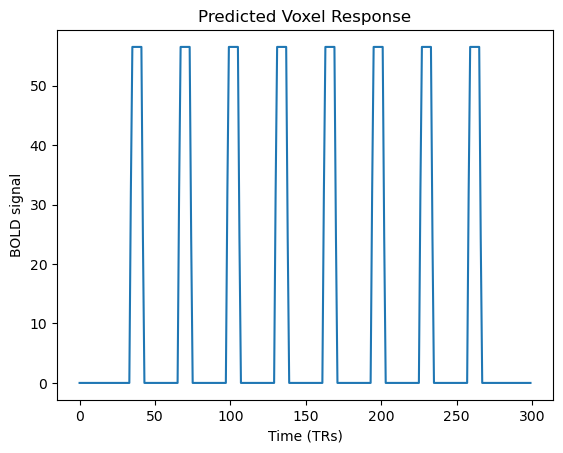

In [18]:
# Example of simulating a voxel response
prf = make_prf_matrix(x0_pix=10, y0_pix=100, sigma_pix=3)
stimulus_matrix=generate_rotating_wedge_stimulus(n_frames=300, height=200, width=200, wedge_width_deg=90, cycle_duration=32, n_cycles=8, blank_duration=22, direction='ccw', radius_px=100)
plt.imshow(stimulus_matrix[150], cmap='gray')
plt.title("Stimulus Frame 150")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
plt.imshow(make_prf_matrix(100, 50, 3))
plt.title("pRF Matrix 1")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
predicted_response = simulate_voxel_response(stimulus_matrix, prf)
plt.plot(predicted_response)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal")
plt.title("Predicted Voxel Response")
plt.show()

(300, 200, 200)


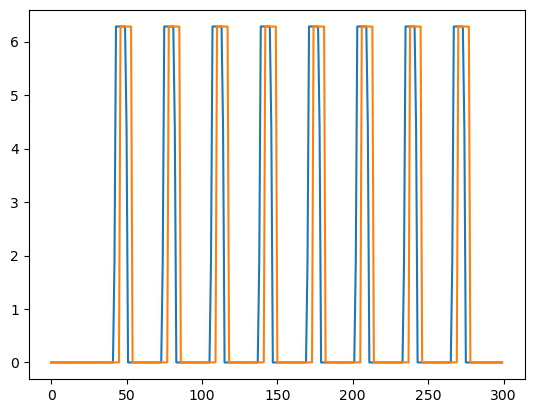

In [19]:
# examples of different x,y values causes different phase in response patterns
r1 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(100, 50, 1))
r2 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(150, 30, 1))
plt.plot(r1)
plt.plot(r2)
print(stimulus_matrix.shape) # (300, 200, 200)

In [20]:
# Select n random V1 voxels
selected_indices_v1 = np.random.choice(v1_voxels, size=15, replace=False)
selected_indices_v2 = np.random.choice(v2_voxels, size=5, replace=False)
selected_indices_v3 = np.random.choice(v3_voxels, size=5, replace=False)
# Extract their BOLD time series
v1_bold_subset = X_hipL[:, selected_indices_v1]
v2_bold_subset = X_hipL[:, selected_indices_v2]
v3_bold_subset = X_hipL[:, selected_indices_v3]
print(X_hipL.shape) # Should be (300, 29696)
print(v1_bold_subset[:,0].shape) # Should be (300,)

(300, 29696)
(300,)


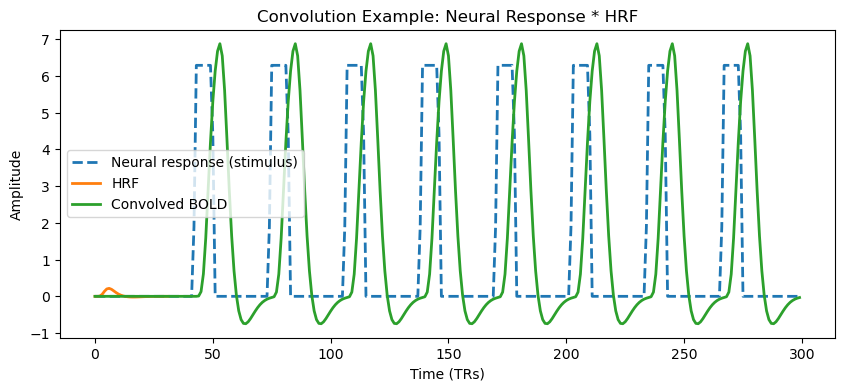

In [21]:
from nilearn.glm.first_level import spm_hrf
from scipy.signal import convolve
# params
n_timepoints = 50
tr = 1.0  # 1s TR
neural_response = simulate_voxel_response(stimulus_matrix, make_prf_matrix(100, 50, 1))
# HRF 
hrf = spm_hrf(tr, oversampling=1)
# convolution
bold_pred = convolve(neural_response, hrf)[:stimulus_matrix.shape[0]]

plt.figure(figsize=(10,4))
plt.plot(neural_response, label="Neural response (stimulus)", lw=2,ls="--")
plt.plot(hrf[:n_timepoints], label="HRF", lw=2)
plt.plot(bold_pred, label="Convolved BOLD", lw=2)
plt.xlabel("Time (TRs)")
plt.ylabel("Amplitude")
plt.title("Convolution Example: Neural Response * HRF")
plt.legend()
plt.show()

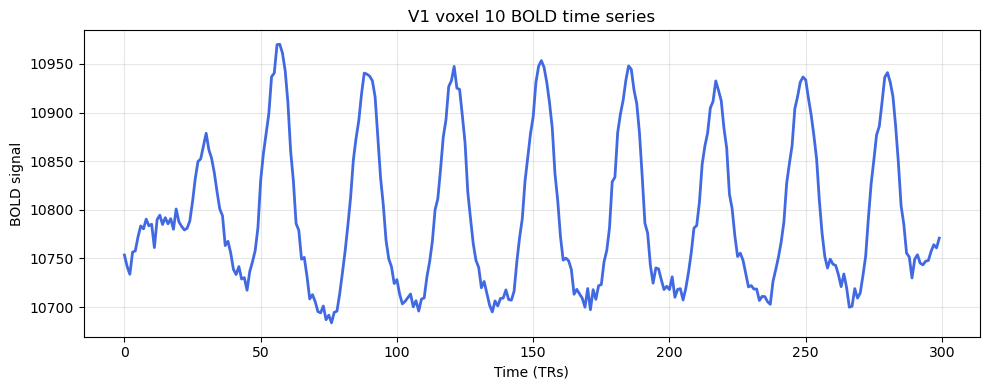

In [22]:
def plot_voxel_timeseries(bold_data,voxel_idx,region_name="V1"):
    bold_ts=bold_data[:, voxel_idx]
    plt.figure(figsize=(10, 4))
    plt.plot(bold_ts, color='royalblue', lw=2)
    plt.title(f"{region_name} voxel {voxel_idx} BOLD time series")
    plt.xlabel("Time (TRs)")
    plt.ylabel("BOLD signal")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# example of V1 voxel 10 response
plot_voxel_timeseries(v1_bold_subset, voxel_idx=10, region_name='V1')

In [23]:
# HRF
hrf = spm_hrf(t_r=1.0,oversampling=1)

# pRF parameter grids
x_grid = np.linspace(0, 199, 30)
y_grid = np.linspace(0, 199, 30)
sigma_grid = np.linspace(3, 15, 10)

bold_data_dict = {
    'V1': v1_bold_subset,
    #'V2': v2_bold_subset,
    #'V3': v3_bold_subset
}

# Storage
all_best_params = []
all_best_r2 = []
all_voxel_labels = []

for region_name, bold_subset in bold_data_dict.items():
    print(f"Processing region: {region_name}")
    n_voxels = bold_subset.shape[1]

    for voxel_idx in range(n_voxels):
        bold_ts = bold_subset[:, voxel_idx]
        bold_ts = (bold_ts - np.mean(bold_ts)) / np.std(bold_ts)
        # initialize MSE
        best_score = np.inf
        # initialize R_sq
        best_rsq = -np.inf
        best_param = [0, 0, 0]

        for x0 in x_grid:
            for y0 in y_grid:
                for sigma in sigma_grid:
                    prf = make_prf_matrix(x0, y0, sigma)
                    neural_response = simulate_voxel_response(stimulus_matrix, prf)
                    bold_pred = convolve(neural_response, hrf)[:len(bold_ts)]
                    bold_pred = (bold_pred - np.mean(bold_pred)) / np.std(bold_pred)

                    ss_res = np.sum((bold_ts - bold_pred) ** 2)
                    ss_tot = np.sum((bold_ts - np.mean(bold_ts)) ** 2)
                    r2 = 1 - ss_res / ss_tot
                    mse = ss_res / len(bold_ts)

                    if mse < best_score:
                        best_score = mse
                        best_rsq = r2
                        best_param = [x0, y0, sigma]

        all_best_params.append(best_param)
        all_best_r2.append(best_rsq)
        all_voxel_labels.append(region_name)

print("\n=== Grid Search Finished ===\n")

# Print with labels
for i, (params, r2, label) in enumerate(zip(all_best_params, all_best_r2, all_voxel_labels)):
    x, y, sigma = np.round(params[0]), np.round(params[1]), np.round(params[2], 3)
    print(f"Voxel {i:02d} ({label}): x={int(x)}, y={int(y)}, sigma={sigma}, R²={r2:.4f}")


Processing region: V1

=== Grid Search Finished ===

Voxel 00 (V1): x=103, y=62, sigma=13.667, R²=0.9158
Voxel 01 (V1): x=130, y=103, sigma=15.0, R²=-0.0295
Voxel 02 (V1): x=124, y=69, sigma=13.667, R²=0.9171
Voxel 03 (V1): x=82, y=178, sigma=4.333, R²=-0.2904
Voxel 04 (V1): x=137, y=96, sigma=15.0, R²=0.1637
Voxel 05 (V1): x=75, y=96, sigma=13.667, R²=0.1521
Voxel 06 (V1): x=103, y=75, sigma=8.333, R²=0.8327
Voxel 07 (V1): x=103, y=89, sigma=15.0, R²=0.2946
Voxel 08 (V1): x=96, y=117, sigma=5.667, R²=-0.2707
Voxel 09 (V1): x=75, y=199, sigma=4.333, R²=-0.4071
Voxel 10 (V1): x=124, y=82, sigma=15.0, R²=0.9057
Voxel 11 (V1): x=124, y=82, sigma=15.0, R²=0.9141
Voxel 12 (V1): x=178, y=62, sigma=15.0, R²=-0.3433
Voxel 13 (V1): x=103, y=110, sigma=7.0, R²=-0.2039
Voxel 14 (V1): x=117, y=62, sigma=12.333, R²=0.9170


In [24]:
def refine_params(best_param,bold_ts,stimulus_matrix,hrf,x_range=5,y_range=5,sigma_range=2):
    n_steps=10
    x0,y0,sigma0=best_param
    x_min=max(0,x0-x_range)
    x_max=min(199,x0+x_range)
    y_min=max(0,y0-y_range)
    y_max=min(199,y0+y_range)
    x_grid=np.linspace(x_min,x_max,n_steps)
    y_grid=np.linspace(y_min,y_max,n_steps)
    sigma_grid=np.linspace(max(1,sigma0-sigma_range),sigma0+sigma_range,n_steps)
    best_score = np.inf
    best_rsq=-np.inf
    refined_param = best_param

    bold_ts=(bold_ts-np.mean(bold_ts))/np.std(bold_ts)
    for x in x_grid:
        for y in y_grid:
            for s in sigma_grid:
                prf=make_prf_matrix(x, y, s)
                neural_resp=simulate_voxel_response(stimulus_matrix, prf)
                pred=convolve(neural_resp, hrf)[:len(bold_ts)]
                
                if np.std(pred) < 1e-6:
                    continue
                pred=(pred-np.mean(pred))/np.std(pred)

                ss_res=np.sum((bold_ts-pred)**2)
                ss_total=np.sum((bold_ts-np.mean(bold_ts))**2)
                r2=1-ss_res/ss_total
                mse=ss_res/len(bold_ts)

                if mse<best_score:
                    best_score=mse
                    best_rsq=r2
                    refined_param=[x,y,s]
    return refined_param,best_rsq

        

In [25]:
refined_params=[]
refined_rsq_list=[]
for i,(param,label) in enumerate(zip(all_best_params,all_voxel_labels)):
    region=label
    bold_ts=bold_data_dict[region][:,i]
    refined_param,refined_rsq=refine_params(param,bold_ts,stimulus_matrix,hrf)
    refined_params.append(refined_param)
    refined_rsq_list.append(refined_rsq) 
    print(f"Voxel {i:02d} ({region}): refined params x={int(refined_param[0])}, y={int(refined_param[1])}, sigma={np.round(refined_param[2],3)}, R_sq={refined_rsq:.4f}")


Voxel 00 (V1): refined params x=103, y=56, sigma=14.778, R_sq=0.9159
Voxel 01 (V1): refined params x=128, y=101, sigma=13.0, R_sq=-0.0287
Voxel 02 (V1): refined params x=119, y=72, sigma=12.111, R_sq=0.9176
Voxel 03 (V1): refined params x=81, y=183, sigma=3.667, R_sq=-0.2904
Voxel 04 (V1): refined params x=135, y=98, sigma=17.0, R_sq=0.1680
Voxel 05 (V1): refined params x=76, y=97, sigma=13.444, R_sq=0.1542
Voxel 06 (V1): refined params x=103, y=76, sigma=8.556, R_sq=0.8336
Voxel 07 (V1): refined params x=104, y=88, sigma=16.111, R_sq=0.2991
Voxel 08 (V1): refined params x=95, y=119, sigma=7.222, R_sq=-0.2705
Voxel 09 (V1): refined params x=77, y=195, sigma=3.222, R_sq=-0.4070
Voxel 10 (V1): refined params x=124, y=80, sigma=15.667, R_sq=0.9068
Voxel 11 (V1): refined params x=121, y=84, sigma=13.444, R_sq=0.9145
Voxel 12 (V1): refined params x=183, y=58, sigma=16.556, R_sq=-0.3433
Voxel 13 (V1): refined params x=104, y=111, sigma=8.556, R_sq=-0.2025
Voxel 14 (V1): refined params x=114,

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

def set_seed():
    seed=42
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [27]:
class PRFDataset(Dataset):
    # shapes
    # bolds: (300,n_voxel) params:(n_voxel,3)
    def __init__(self,bolds,params):
        if bolds.shape[0]!=300:
            bolds=bolds.T
        
        self.X=torch.tensor(bolds,dtype=torch.float32)
        self.y=torch.tensor(params,dtype=torch.float32)
        self.X=(self.X-self.X.mean(dim=1))/(self.X.std(dim=1)+1e-8)
        self.N, self.T=self.X.shape
    def __len__(self):
        return self.N
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    

In [28]:
class PRFNet(nn.Module):
    def __init__(self,T,hidden=256,output_scale=(200,200,30)):
        super().__init__()
        self.fc1=nn.Linear(T,hidden)
        self.fc2=nn.Linear(hidden,hidden//2)
        self.fc3=nn.Linear(hidden//2,3)
        self.droupout=nn.Dropout(0.2)
    def forward(self,x):
        h=F.relu(self.fc1(x))
        h=self.dropout(h)
        h=F.relu(self.fc2(h))
        out=self.fc3(h)
        out=self.sigmoid(out)*self.out_scale
        out[:,2]=torch.clamp(out[:,2],min=1.0)
        return out


In [29]:
def make_gaussian(H,W,x,y,sigma):
    ys=torch.arange(H,dtype=torch.float32)
    xs=torch.arange(W,dtype=torch.float32)
    Y,X[torch.meshgrid(ys,xs,indexing='ij')]
    g=torch.exp(-((X-x)**2+(Y-y)**2))/(2*sigma**2)
    return g

In [32]:
def predict_bold(params,stimulus,hrf):
    T,H,W=stimulus.shape # (300,200,200)
    B=params.shape[0] 
    preds=[]
    for i in range(B):
        x,y,sigma=params[i]
        prf=make_gaussian(H,W,x,y,sigma)
        neural=(stimulus * prf.unsqueeze(0)).view(T, -1).sum(dim=1)
        neural_=neural.view(1,1,T)
        hrf_=hrf.view(1,1,-1)
        conv=F.conv1d(neural_,hrf_,padding=0).view(-1)
        conv=conv[:T]
        preds.append(conv)
    preds=torch.stack(preds,dim=0)
    return preds

In [36]:
def train(model, dataset, stimulus_np, hrf_np, device='cpu',
          lr=1e-3, batch_size=32, n_epochs=50, alpha_param=1.0, alpha_pred=0.2, val_split=0.1):
    device = torch.device(device)
    model = model.to(device)
    # prepare stimulus and hrf tensors on device
    stimulus_tensor = torch.tensor(stimulus_np, dtype=torch.float32, device=device)  # (T,H,W)
    hrf_tensor = torch.tensor(hrf_np, dtype=torch.float32, device=device).view(-1)
    # dataloaders
    N = len(dataset)
    idxs = np.arange(N) 
    np.random.shuffle(idxs)
    n_val = max(1, int(val_split * N))
    train_idx = idxs[n_val:] 
    val_idx = idxs[:n_val]
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    val_loader   = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_idx))
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    history = {'train_loss':[], 'val_loss':[]}
    for epoch in range(1, n_epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)  # (B,T) normalized
            yb = yb.to(device)  # (B,3)
            opt.zero_grad()
            pred_params = model(xb)
            loss_param = mse(pred_params, yb)
            # pred-BOLD loss (optional)
            pred_bold = predict_bold(pred_params, stimulus_tensor, hrf_tensor, device)  # (B,T)
            # normalize predicted bold to match normalized xb
            pred_bold = (pred_bold - pred_bold.mean(dim=1,keepdim=True)) / (pred_bold.std(dim=1))
            loss_pred = mse(pred_bold, xb)
            loss = alpha_param * loss_param + alpha_pred * loss_pred
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.sampler)
        # val
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for vb, vp in val_loader:
                vb = vb.to(device); vp = vp.to(device)
                pp = model(vb)
                loss_p = mse(pp, vp).item()
                pb = predict_bold(pp, stimulus_tensor, hrf_tensor, device)
                pb = (pb - pb.mean(dim=1,keepdim=True)) / (pb.std(dim=1,keepdim=True)+1e-8)
                loss_pb = mse(pb, vb).item()
                running_val += (alpha_param * loss_p + alpha_pred * loss_pb) * vb.size(0)
        val_loss = running_val / len(val_loader.sampler)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        print(f"Epoch {epoch}/{n_epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
    return model, history